In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
df = pd.read_csv('data/critics.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27631 entries, 0 to 27630
Data columns (total 8 columns):
critic         23740 non-null object
fresh          27631 non-null object
imdb           27631 non-null int64
publication    27631 non-null object
quote          15561 non-null object
review_date    27631 non-null object
rtid           27631 non-null int64
title          27631 non-null object
dtypes: int64(2), object(6)
memory usage: 1.7+ MB
None


,critic,fresh,imdb,publication,quote,review_date,rtid,title
0,Owen Gleiberman,fresh,114709,Entertainment Weekly,NaN,2011-09-07,9559,Toy story
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story


In [3]:
df.fresh.value_counts()

fresh     11821
rotten     8420
none       7390
Name: fresh, dtype: int64

In [4]:
df = df[df.fresh != 'none']

In [5]:
# Drop rows with missing quotes:
df = df[~df.quote.isnull()]

df.rename(columns={
    'fresh': 'freshness',
    'title': 'movie',
    'quote': 'review_quote'
}, inplace=True)

df['fresh'] = (df.freshness == 'fresh').astype(int)
df.tail()

,critic,freshness,imdb,publication,review_quote,review_date,rtid,movie,fresh
27606,Ronald Holloway,fresh,86005,Variety,Measures up to the promise Ballard amply provi...,2008-07-23,12606,Never Cry Wolf,1
27607,NaN,fresh,86005,Time Out,"For the most part very absorbing, the film suf...",2006-01-26,12606,Never Cry Wolf,1
27608,Vincent Canby,fresh,86005,New York Times,Perhaps the best thing about the film is that ...,2004-08-30,12606,Never Cry Wolf,1
27609,Dave Kehr,fresh,86005,Chicago Reader,The film is still memorable for its compassion...,2000-01-01,12606,Never Cry Wolf,1
27616,Don Druker,fresh,55353,Chicago Reader,It does have enough gritty insights and (for t...,2007-11-13,18541,A Raisin in the Sun,1


In [6]:
n_reviews = len(df)
n_movies = df.movie.unique().size
n_critics = df.critic.unique().size
n_pubs = df.publication.unique().size

print("Number of reviews: {:d}".format(n_reviews))
print("Number of movies:  {:d}".format(n_movies))
print("Number of critics: {:d}".format(n_critics))
print("Number of publications:  {:d}".format(n_pubs))
print()
print("Average review freshness: {:0.0f}%".format(df.fresh.mean()*100))

Number of reviews: 15534
Number of movies:  1921
Number of critics: 622
Number of publications:  65

Average review freshness: 61%


---
## ROTTEN TOMATOES REVIEWS

In [7]:
# save features and target as acceptable datatypes:
X = df.review_quote.values.astype('str')
y = df.fresh.values.astype('int')

#### Vectorize First

In [8]:
def vectorize_split_classify(X, y, tfidf=False):
    if tfidf:
        vectorizer = TfidfVectorizer()
        print('TFIDF VECTORIZER')
    else:
        vectorizer = CountVectorizer()
        print('COUNT VECTORIZER')
        
    X = vectorizer.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=32)

    clf = MultinomialNB().fit(X_train, y_train)

    print("\tAccuracy on Training Data: {:0.2f}%".format(clf.score(X_train, y_train)*100))
    print("\t    Accuracy on Test Data: {:0.2f}%".format(clf.score(X_test, y_test)*100))

In [9]:
vectorize_split_classify(X, y, tfidf=False)
print()
vectorize_split_classify(X, y, tfidf=True)

COUNT VECTORIZER
	Accuracy on Training Data: 92.03%
	    Accuracy on Test Data: 76.67%

TFIDF VECTORIZER
	Accuracy on Training Data: 80.67%
	    Accuracy on Test Data: 69.10%


#### Train/Test Split First

In [10]:
def split_vectorize_classify(X, y, tfidf=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=32)
    
    if tfidf:
        vectorizer = TfidfVectorizer()
        X_train = vectorizer.fit_transform(X_train)
        X_test = vectorizer.transform(X_test)
        print('TFIDF VECTORIZER')
    else:
        vectorizer = CountVectorizer()
        X_train = vectorizer.fit_transform(X_train)
        X_test = vectorizer.transform(X_test)
        print('COUNT VECTORIZER')
        
    clf = MultinomialNB().fit(X_train, y_train)

    print("\tAccuracy on Training Data: {:0.2f}%".format(clf.score(X_train, y_train)*100))
    print("\t    Accuracy on Test Data: {:0.2f}%".format(clf.score(X_test, y_test)*100))

In [11]:
split_vectorize_classify(X, y, tfidf=False)
print()
split_vectorize_classify(X, y, tfidf=True)

COUNT VECTORIZER
	Accuracy on Training Data: 92.19%
	    Accuracy on Test Data: 76.80%

TFIDF VECTORIZER
	Accuracy on Training Data: 81.89%
	    Accuracy on Test Data: 69.31%


### Hyper-Parameter Tuning

In [12]:
import txt_clfy
import hide_output

parameters = {
    'vect__min_df': (1e-5, 1e-4, 1e-3, 1e-2, 1e-1),
    'vect__max_df': (0.25, 0.5, 0.75, 1.0),
    'clf__alpha': (0.1, 1, 5, 10),
    'clf__fit_prior': (True, False)
}

print()
clf_count, vectorizer_count, confusion_count = txt_clfy.split_vectorize_classify(X, y, parameters)
print('_'*65)
print()
clf_tfidf, vectorizer_tfidf, confusion_tfidf = txt_clfy.split_vectorize_classify(X, y, parameters, tfidf=True)
print()


COUNT VECTORIZER
Best Score: 76.77%

clf__alpha
	searched=(0.1, 1, 5, 10)
	best=1

clf__fit_prior
	searched=(True, False)
	best=False

vect__max_df
	searched=(0.25, 0.5, 0.75, 1.0)
	best=0.5

vect__min_df
	searched=(1e-05, 0.0001, 0.001, 0.01, 0.1)
	best=1e-05

Accuracy on Training Data: 92.11%
    Accuracy on Test Data: 77.03%
_________________________________________________________________

TFIDF VECTORIZER
Best Score: 76.48%

clf__alpha
	searched=(0.1, 1, 5, 10)
	best=1

clf__fit_prior
	searched=(True, False)
	best=False

vect__max_df
	searched=(0.25, 0.5, 0.75, 1.0)
	best=0.25

vect__min_df
	searched=(1e-05, 0.0001, 0.001, 0.01, 0.1)
	best=1e-05

Accuracy on Training Data: 91.43%
    Accuracy on Test Data: 76.62%



### Hyper-Parameter Tuning with a Custom Metric

In [13]:
print()
clf_count_ml, vectorizer_count_ml, confusion_count_ml = txt_clfy.split_vect_clfy_maxlikelihood(X, y, parameters)
print('_'*65)
print()
clf_tfidf_ml, vectorizer_tfidf_ml, confusion_tfidf_ml = txt_clfy.split_vect_clfy_maxlikelihood(X, y, parameters, tfidf=True)
print()


COUNT VECTORIZER
Best min_df: 0.0001
Best max_df: 0.25
Best alpha: 5
Best fit_prior: False

Accuracy on Training Data: 86.16%
    Accuracy on Test Data: 76.54%
_________________________________________________________________

TFIDF VECTORIZER
Best min_df: 0.0001
Best max_df: 0.5
Best alpha: 0.1
Best fit_prior: True

Accuracy on Training Data: 91.68%
    Accuracy on Test Data: 76.03%



In [14]:
clf = clf_count_ml
vectorizer = vectorizer_count_ml
confusion = confusion_count_ml

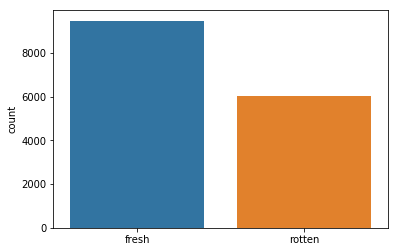

In [15]:
sns.countplot(df.freshness)
plt.xlabel('');

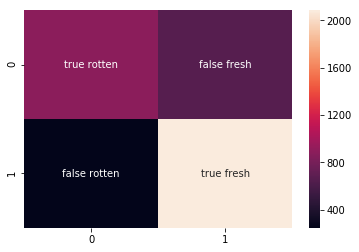

In [16]:
labels = np.array([['true rotten','false fresh'], ['false rotten','true fresh']])
sns.heatmap(confusion, annot=labels, fmt='');

### Predictive Words (Features)

In [17]:
words = np.array(vectorizer.get_feature_names())

# Save identity matrix where each row represents exactly one feature (word):
x = np.identity(len(words))

# Use the trained model to classify individual words as reviews and return the probability:
probability = clf.predict_log_proba(x)[:, 0]

# Sort (ascending) the matrix rows by probability and return the corresponding indices:
indices = np.argsort(probability)

# Filter the words list to find the ten most likely to indicate fresh or rotten:
fresh_words = words[indices[:10]]
rotten_words = words[indices[-10:]]

fresh_prob = probability[indices[:10]]
rotten_prob = probability[indices[-10:]]

# Display 10 most fresh and rotten words with the probability that the word is fresh:
print('Fresh words\t\tP(fresh|word)')
for word, p in zip(fresh_words, fresh_prob):
    print('{:>20}'.format(word), '\t{:0.2f}'.format(1 - np.exp(p)))

print()

print('Rotten words\t\tP(fresh|word)')
for word, p in zip(rotten_words, rotten_prob):
    print('{:>20}'.format(word), '\t{:0.2f}'.format(1 - np.exp(p)))

Fresh words		P(fresh|word)
            touching 	0.86
             delight 	0.86
        entertaining 	0.86
         masterpiece 	0.85
             perfect 	0.84
          delightful 	0.83
            powerful 	0.82
          remarkable 	0.82
               smart 	0.82
              finest 	0.82

Rotten words		P(fresh|word)
      disappointment 	0.16
            tiresome 	0.16
               video 	0.16
             unfunny 	0.15
             problem 	0.15
                dull 	0.14
               bland 	0.14
          uninspired 	0.14
       unfortunately 	0.12
                lame 	0.10


### Incorrectly Classified Reviews

In [18]:
# Save probability for all observations:
probability = clf.predict_proba(vectorizer.transform(X))[:, 0]

# Filter by true class, sort and save the index for top and bottom values:
wrong_rotten = np.argsort(probability[y == 0])[:5]
wrong_fresh = np.argsort(probability[y == 1])[-5:]

print('Top 5 Incorrectly Classified Rotten Reviews')
print('-------------------------------------------')
for row in wrong_rotten:
    print(df[y == 0].review_quote.iloc[row], '({})'.format(df[y == 0].movie.iloc[row]))
    print()

print('Top 5 Incorrectly Classified Fresh Reviews')
print('------------------------------------------')
for row in wrong_fresh:
    print(df[y == 1].review_quote.iloc[row], '({})'.format(df[y == 1].movie.iloc[row]))
    print()

Top 5 Incorrectly Classified Rotten Reviews
-------------------------------------------
Part comedy, part family drama, part romance, part special-effects mystery-adventure, and not entirely satisfying on any of these levels. (Practical Magic)

I'll let you in on a little secret that film critics have known for years. A major studio production, released in August with top-list stars, is almost certain to be a gobbler. (The Time Traveler's Wife)

The movie plays like the kind of line a rich older guy would lay on a teenage model, suppressing his own intelligence and irony in order to spread out before her the wonderful world he would like to give her as a gift. (Stealing Beauty)

An ambitious, serious but not particularly stimulating musical feature that unconvincingly attempts to graft warm and cuddly family-film motifs onto turbulent aspects of modern history and mythology. (Anastasia)

It survives today only as an unusually pure example of a typical 50s art-film strategy: the attempt

### Predict Freshness of New Reviews

In [19]:
reviews = [
    ["This movie is not remarkable in any way."],
    ["The movie is remarkable in every way!"],
    ["Airplane! never gets old. My kid laughed throughout the entire thirty-something year old classic."],
    ["The only hours I've ever wished to have back were the two I spent watching Inception."]
]
print()
for review in reviews:
    transformed = vectorizer.transform(review)
    print('"{}"'.format(review[0]))
    if clf.predict(transformed) == 1:
        print('Prediction: {:0.2f}% likely FRESH\n'.format(clf.predict_proba(transformed)[0][1]*100))
    else:
        print('Prediction: {:0.2f}% likely ROTTEN\n'.format(clf.predict_proba(transformed)[0][0]*100))


"This movie is not remarkable in any way."
Prediction: 89.53% likely FRESH

"The movie is remarkable in every way!"
Prediction: 89.09% likely FRESH

"Airplane! never gets old. My kid laughed throughout the entire thirty-something year old classic."
Prediction: 87.84% likely FRESH

"The only hours I've ever wished to have back were the two I spent watching Inception."
Prediction: 77.56% likely ROTTEN



---
## N-GRAMS

In [20]:
print('Minimum 1 word, Maximum 2 words')
print()
clf_count_1_2_ml, vectorizer_count_1_2_ml, confusion_count_1_2_ml = txt_clfy.split_vect_clfy_maxlikelihood(X, y, parameters, ngram_range=(1, 2))
print('_'*65)
print()
clf_tfidf_1_2_ml, vectorizer_tfidf_1_2_ml, confusion_tfidf_1_2_ml = txt_clfy.split_vect_clfy_maxlikelihood(X, y, parameters, tfidf=True, ngram_range=(1, 2))
print()

Minimum 1 word, Maximum 2 words

COUNT VECTORIZER
Best min_df: 0.001
Best max_df: 0.25
Best alpha: 10
Best fit_prior: True

Accuracy on Training Data: 79.02%
    Accuracy on Test Data: 72.35%
_________________________________________________________________

TFIDF VECTORIZER
Best min_df: 1e-05
Best max_df: 0.5
Best alpha: 0.1
Best fit_prior: False

Accuracy on Training Data: 99.95%
    Accuracy on Test Data: 77.27%



In [21]:
clf = clf_count_1_2_ml
vectorizer = vectorizer_count_1_2_ml
confusion = confusion_count_1_2_ml

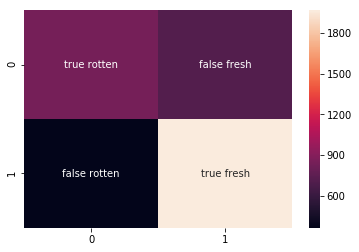

In [22]:
sns.heatmap(confusion, annot=labels, fmt='');

### Predictive Words/Phrases (Features)

In [23]:
words = np.array(vectorizer.get_feature_names())

# Save identity matrix where each row represents exactly one feature (word):
x = np.identity(len(words))

# Use the trained model to classify individual words as reviews and return the probability:
probability = clf.predict_log_proba(x)[:, 0]

# Sort (ascending) the matrix rows by probability and return the corresponding indices:
indices = np.argsort(probability)

# Filter the words list to find the ten most likely to indicate fresh or rotten:
fresh_words = words[indices[:10]]
rotten_words = words[indices[-10:]]

fresh_prob = probability[indices[:10]]
rotten_prob = probability[indices[-10:]]

# Display 10 most fresh and rotten words with the probability that the word is fresh:
print('Fresh  words/phrases\tP(fresh|word/phrase)')
for word, p in zip(fresh_words, fresh_prob):
    print('{:>20}'.format(word), '\t{:0.2f}'.format(1 - np.exp(p)))

print()

print('Rotten words/phrases\tP(fresh|word/phrase)')
for word, p in zip(rotten_words, rotten_prob):
    print('{:>20}'.format(word), '\t{:0.2f}'.format(1 - np.exp(p)))

Fresh  words/phrases	P(fresh|word/phrase)
        entertaining 	0.89
            the best 	0.86
             perfect 	0.85
            touching 	0.85
         masterpiece 	0.85
             delight 	0.84
              one of 	0.84
               smart 	0.84
            powerful 	0.84
         performance 	0.83

Rotten words/phrases	P(fresh|word/phrase)
      disappointment 	0.31
               fails 	0.30
             unfunny 	0.29
          uninspired 	0.28
               video 	0.27
               bland 	0.26
             problem 	0.26
                dull 	0.25
       unfortunately 	0.23
                lame 	0.23


### Incorrectly Classified Reviews

In [24]:
# Save probability for all observations:
probability = clf.predict_proba(vectorizer.transform(X))[:, 0]

# Filter by true class, sort and save the index for top and bottom values:
wrong_rotten = np.argsort(probability[y == 0])[:5]
wrong_fresh = np.argsort(probability[y == 1])[-5:]

print('Top 5 Incorrectly Classified Rotten Reviews')
print('-------------------------------------------')
for row in wrong_rotten:
    print(df[y == 0].review_quote.iloc[row], '({})'.format(df[y == 0].movie.iloc[row]))
    print()

print('Top 5 Incorrectly Classified Fresh Reviews')
print('------------------------------------------')
for row in wrong_fresh:
    print(df[y == 1].review_quote.iloc[row], '({})'.format(df[y == 1].movie.iloc[row]))
    print()

Top 5 Incorrectly Classified Rotten Reviews
-------------------------------------------
It is sometimes funny in a puzzling kind of way, it is generally overwrought in an irritating kind of way, and once in a while it is inappropriately touching. (Carrie)

Walken is one of the few undeniably charismatic male villains of recent years; he can generate a snakelike charm that makes his worst characters the most memorable, and here he operates on pure style. (King of New York)

With its feints at horror and pathos, the third Star Wars film is the most Disney-esque in its emotional outline, yet that outline is buried beneath an obnoxiously hyped-up pace that reduces the emotions to rubble. (Star Wars: Episode VI - Return of the Jedi)

Benefits from a lively lead performance by the miscast Denzel Washington but doesn't come within light years of the book, one of the greatest American autobiographies. (Malcolm X)

The best shot in this film is the first one. Not a good sign. (I Know What You D

### Predict Freshness of New Reviews

In [25]:
reviews = [
    ["This movie is not remarkable in any way."],
    ["The movie is remarkable in every way!"],
    ["Airplane! never gets old. My kid laughed throughout the entire thirty-something year old classic."],
    ["The only hours I've ever wished to have back were the two I spent watching Inception."]
]
print()
for review in reviews:
    transformed = vectorizer.transform(review)
    print('"{}"'.format(review[0]))
    if clf.predict(transformed) == 1:
        print('Prediction: {:0.2f}% likely FRESH\n'.format(clf.predict_proba(transformed)[0][1]*100))
    else:
        print('Prediction: {:0.2f}% likely ROTTEN\n'.format(clf.predict_proba(transformed)[0][0]*100))


"This movie is not remarkable in any way."
Prediction: 77.38% likely FRESH

"The movie is remarkable in every way!"
Prediction: 76.83% likely FRESH

"Airplane! never gets old. My kid laughed throughout the entire thirty-something year old classic."
Prediction: 70.05% likely FRESH

"The only hours I've ever wished to have back were the two I spent watching Inception."
Prediction: 89.54% likely ROTTEN

